In [1]:
import h5py
from pathlib import Path

path = Path("/mnt/raid0/AgiBot_Word_Beta/proprio_stats/358/654803/proprio_stats.h5")

def walk(name, obj, indent=0):
    prefix = "  " * indent
    if isinstance(obj, h5py.Group):
        print(f"{prefix}{name}/")
        for k, v in obj.items():
            walk(k, v, indent + 1)
    else:
        print(f"{prefix}{name}  [shape={obj.shape}, dtype={obj.dtype}]")

with h5py.File(path, "r") as f:
    for k, v in f.items():
        walk(k, v, 0)


action/
  effector/
    force  [shape=(0,), dtype=float32]
    index  [shape=(1422,), dtype=int64]
    position  [shape=(1422, 2), dtype=float64]
  end/
    index  [shape=(1295,), dtype=int64]
    orientation  [shape=(1422, 2, 4), dtype=float64]
    position  [shape=(1422, 2, 3), dtype=float64]
  head/
    index  [shape=(1422,), dtype=int64]
    position  [shape=(1422, 2), dtype=float64]
  joint/
    effort  [shape=(0,), dtype=float32]
    index  [shape=(1295,), dtype=int64]
    position  [shape=(1422, 14), dtype=float64]
    velocity  [shape=(0,), dtype=float32]
  robot/
    angular  [shape=(0,), dtype=float32]
    index  [shape=(1422,), dtype=int64]
    orientation  [shape=(0,), dtype=float32]
    position  [shape=(0,), dtype=float32]
    velocity  [shape=(1422, 2), dtype=float64]
  waist/
    index  [shape=(1422,), dtype=int64]
    position  [shape=(1422, 2), dtype=float64]
state/
  effector/
    force  [shape=(0,), dtype=float32]
    position  [shape=(1422, 2), dtype=float64]
  end

Action position shape: (1422, 2, 3)
Action orientation shape: (1422, 2, 4)
State position shape: (1422, 2, 3)
State orientation shape: (1422, 2, 4)


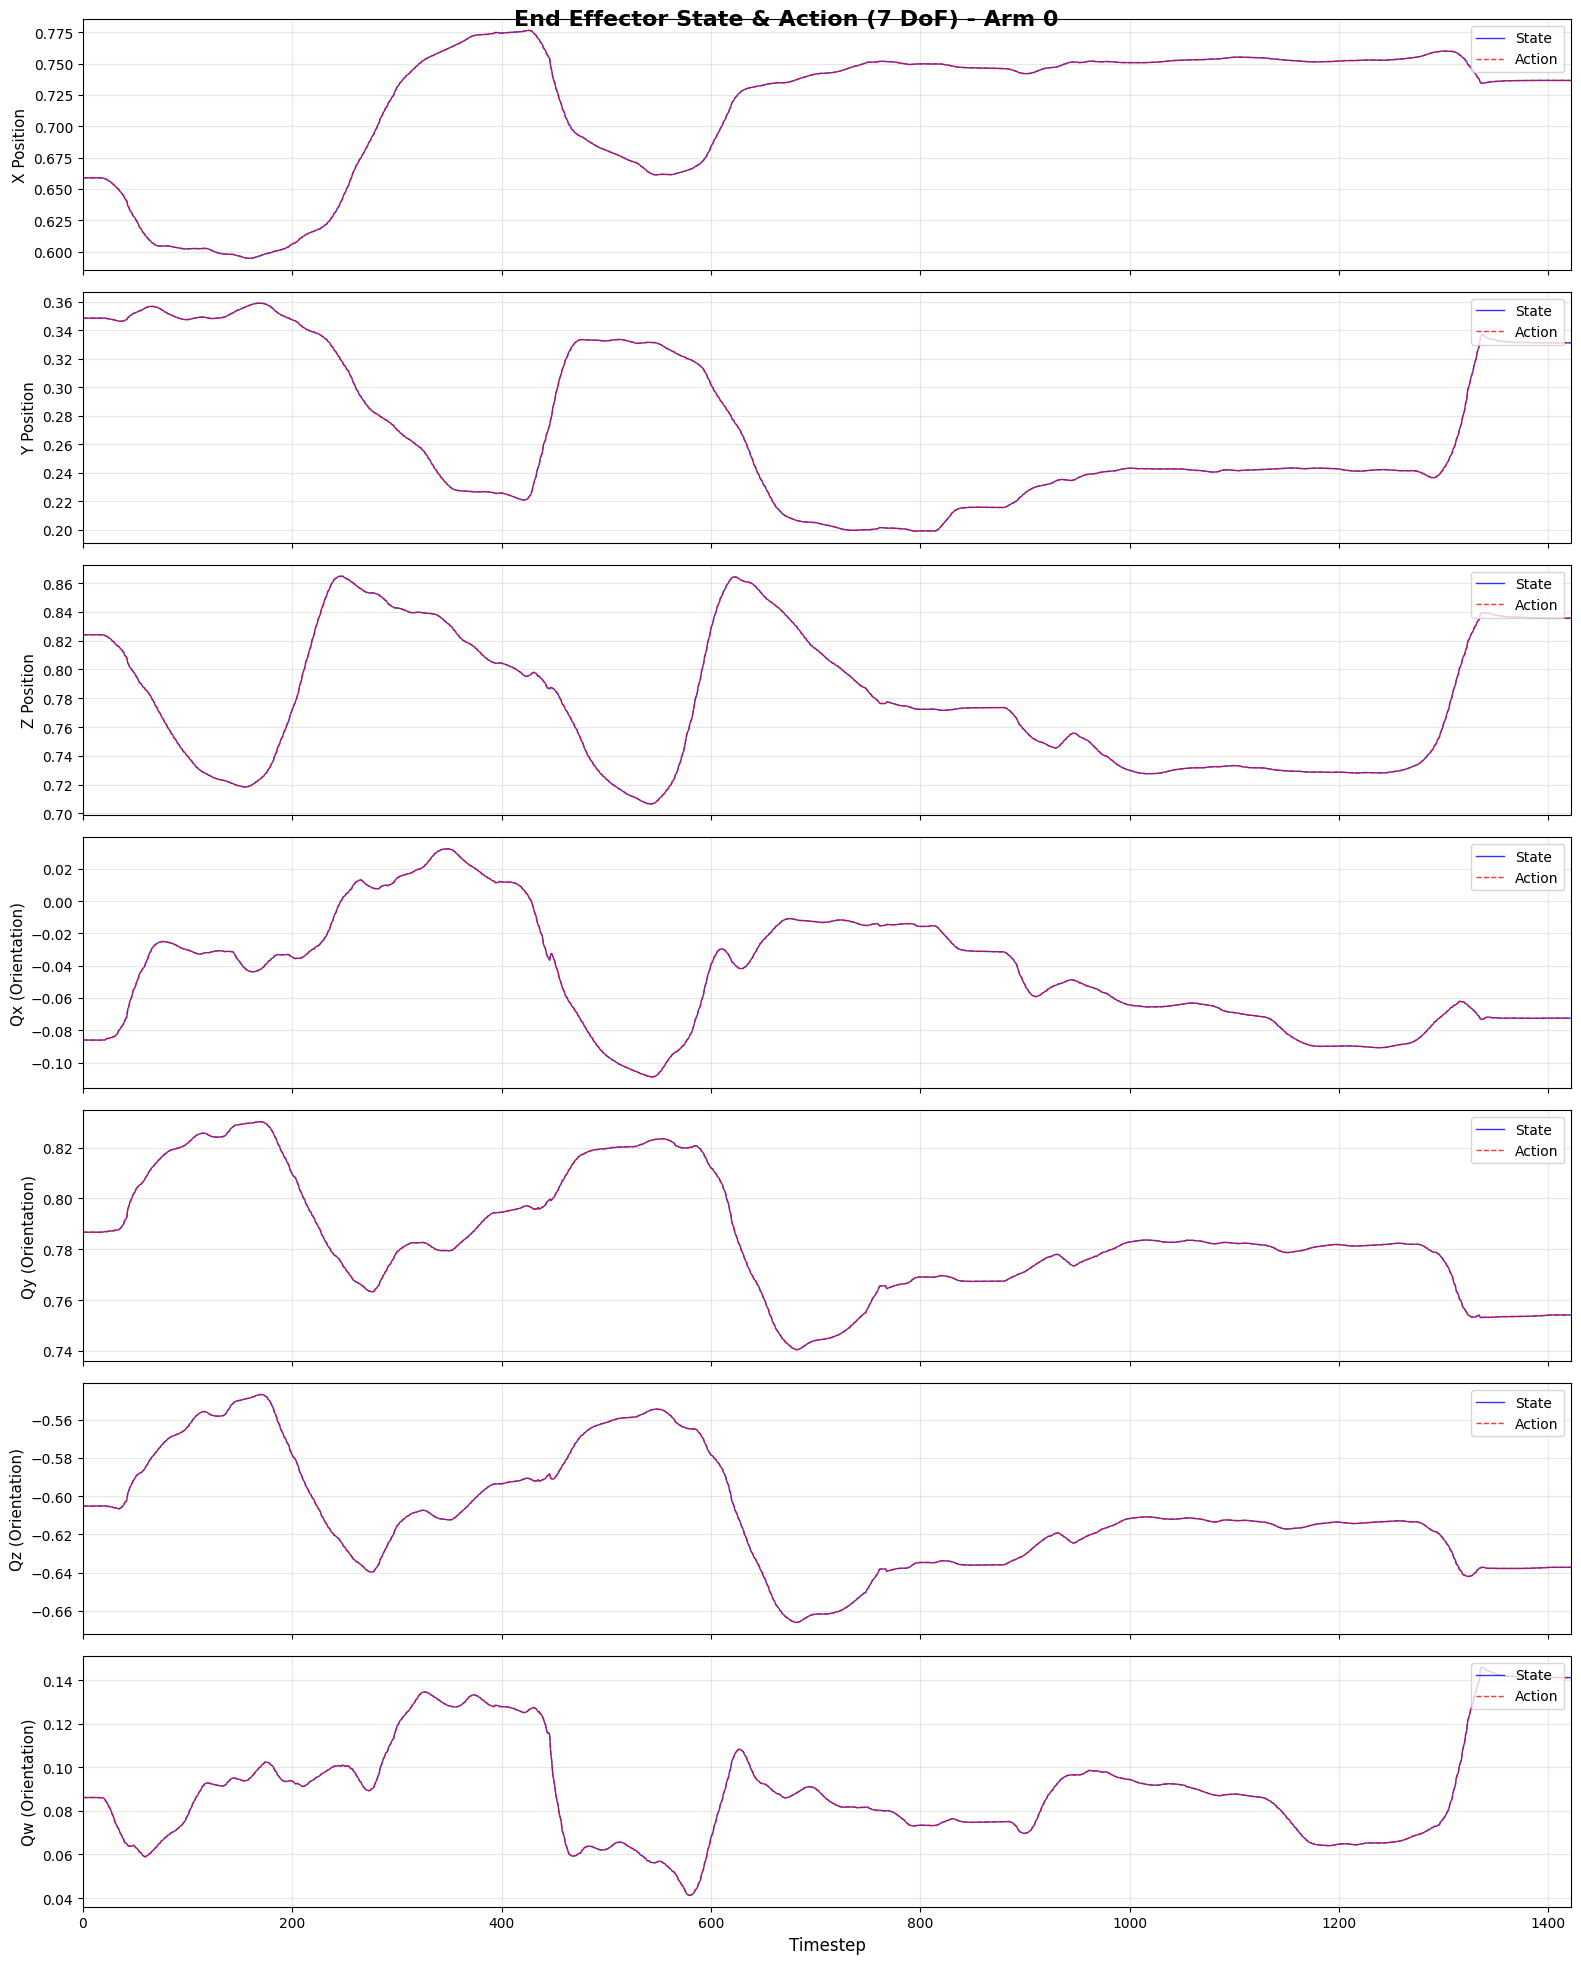

In [3]:
"""
绘制 state 和 action 的末端执行器 7 自由度曲线
- position (3D): x, y, z
- orientation (4D): qx, qy, qz, qw (四元数)
"""

import matplotlib.pyplot as plt
import numpy as np


# 读取数据
with h5py.File(path, "r") as f:
    # Action: end effector
    action_position = f["action/end/position"][:]      # (2418, 2, 3)
    action_orientation = f["action/end/orientation"][:]  # (2418, 2, 4)
    
    # State: end effector
    state_position = f["state/end/position"][:]        # (2418, 2, 3)
    state_orientation = f["state/end/orientation"][:]    # (2418, 2, 4)

print(f"Action position shape: {action_position.shape}")
print(f"Action orientation shape: {action_orientation.shape}")
print(f"State position shape: {state_position.shape}")
print(f"State orientation shape: {state_orientation.shape}")

# 时间轴
timesteps = np.arange(action_position.shape[0])  # 2418

# 我们绘制第一个末端执行器 (index 0)，如果有两个的话
arm_idx = 0  # 可以改成 1 查看另一个手臂

# 提取数据
action_pos = action_position[:, arm_idx, :]  # (2418, 3)
action_ori = action_orientation[:, arm_idx, :]  # (2418, 4)
state_pos = state_position[:, arm_idx, :]  # (2418, 3)
state_ori = state_orientation[:, arm_idx, :]  # (2418, 4)

# 创建图表 - 7个子图
fig, axes = plt.subplots(7, 1, figsize=(16, 20), sharex=True)
fig.suptitle(f'End Effector State & Action (7 DoF) - Arm {arm_idx}', fontsize=16, fontweight='bold')

# 位置标签
pos_labels = ['X Position', 'Y Position', 'Z Position']
# 四元数标签
ori_labels = ['Qx (Orientation)', 'Qy (Orientation)', 'Qz (Orientation)', 'Qw (Orientation)']

# 绘制位置 (3个维度)
for i in range(3):
    ax = axes[i]
    ax.plot(timesteps, state_pos[:, i], 'b-', label='State', alpha=0.8, linewidth=1)
    ax.plot(timesteps, action_pos[:, i], 'r--', label='Action', alpha=0.8, linewidth=1)
    ax.set_ylabel(pos_labels[i], fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, len(timesteps)])

# 绘制姿态/四元数 (4个维度)
for i in range(4):
    ax = axes[3 + i]
    ax.plot(timesteps, state_ori[:, i], 'b-', label='State', alpha=0.8, linewidth=1)
    ax.plot(timesteps, action_ori[:, i], 'r--', label='Action', alpha=0.8, linewidth=1)
    ax.set_ylabel(ori_labels[i], fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, len(timesteps)])

# 设置x轴标签
axes[-1].set_xlabel('Timestep', fontsize=12)

plt.tight_layout()
plt.show()

Action joint position shape: (1422, 14)
State joint position shape: (1422, 14)


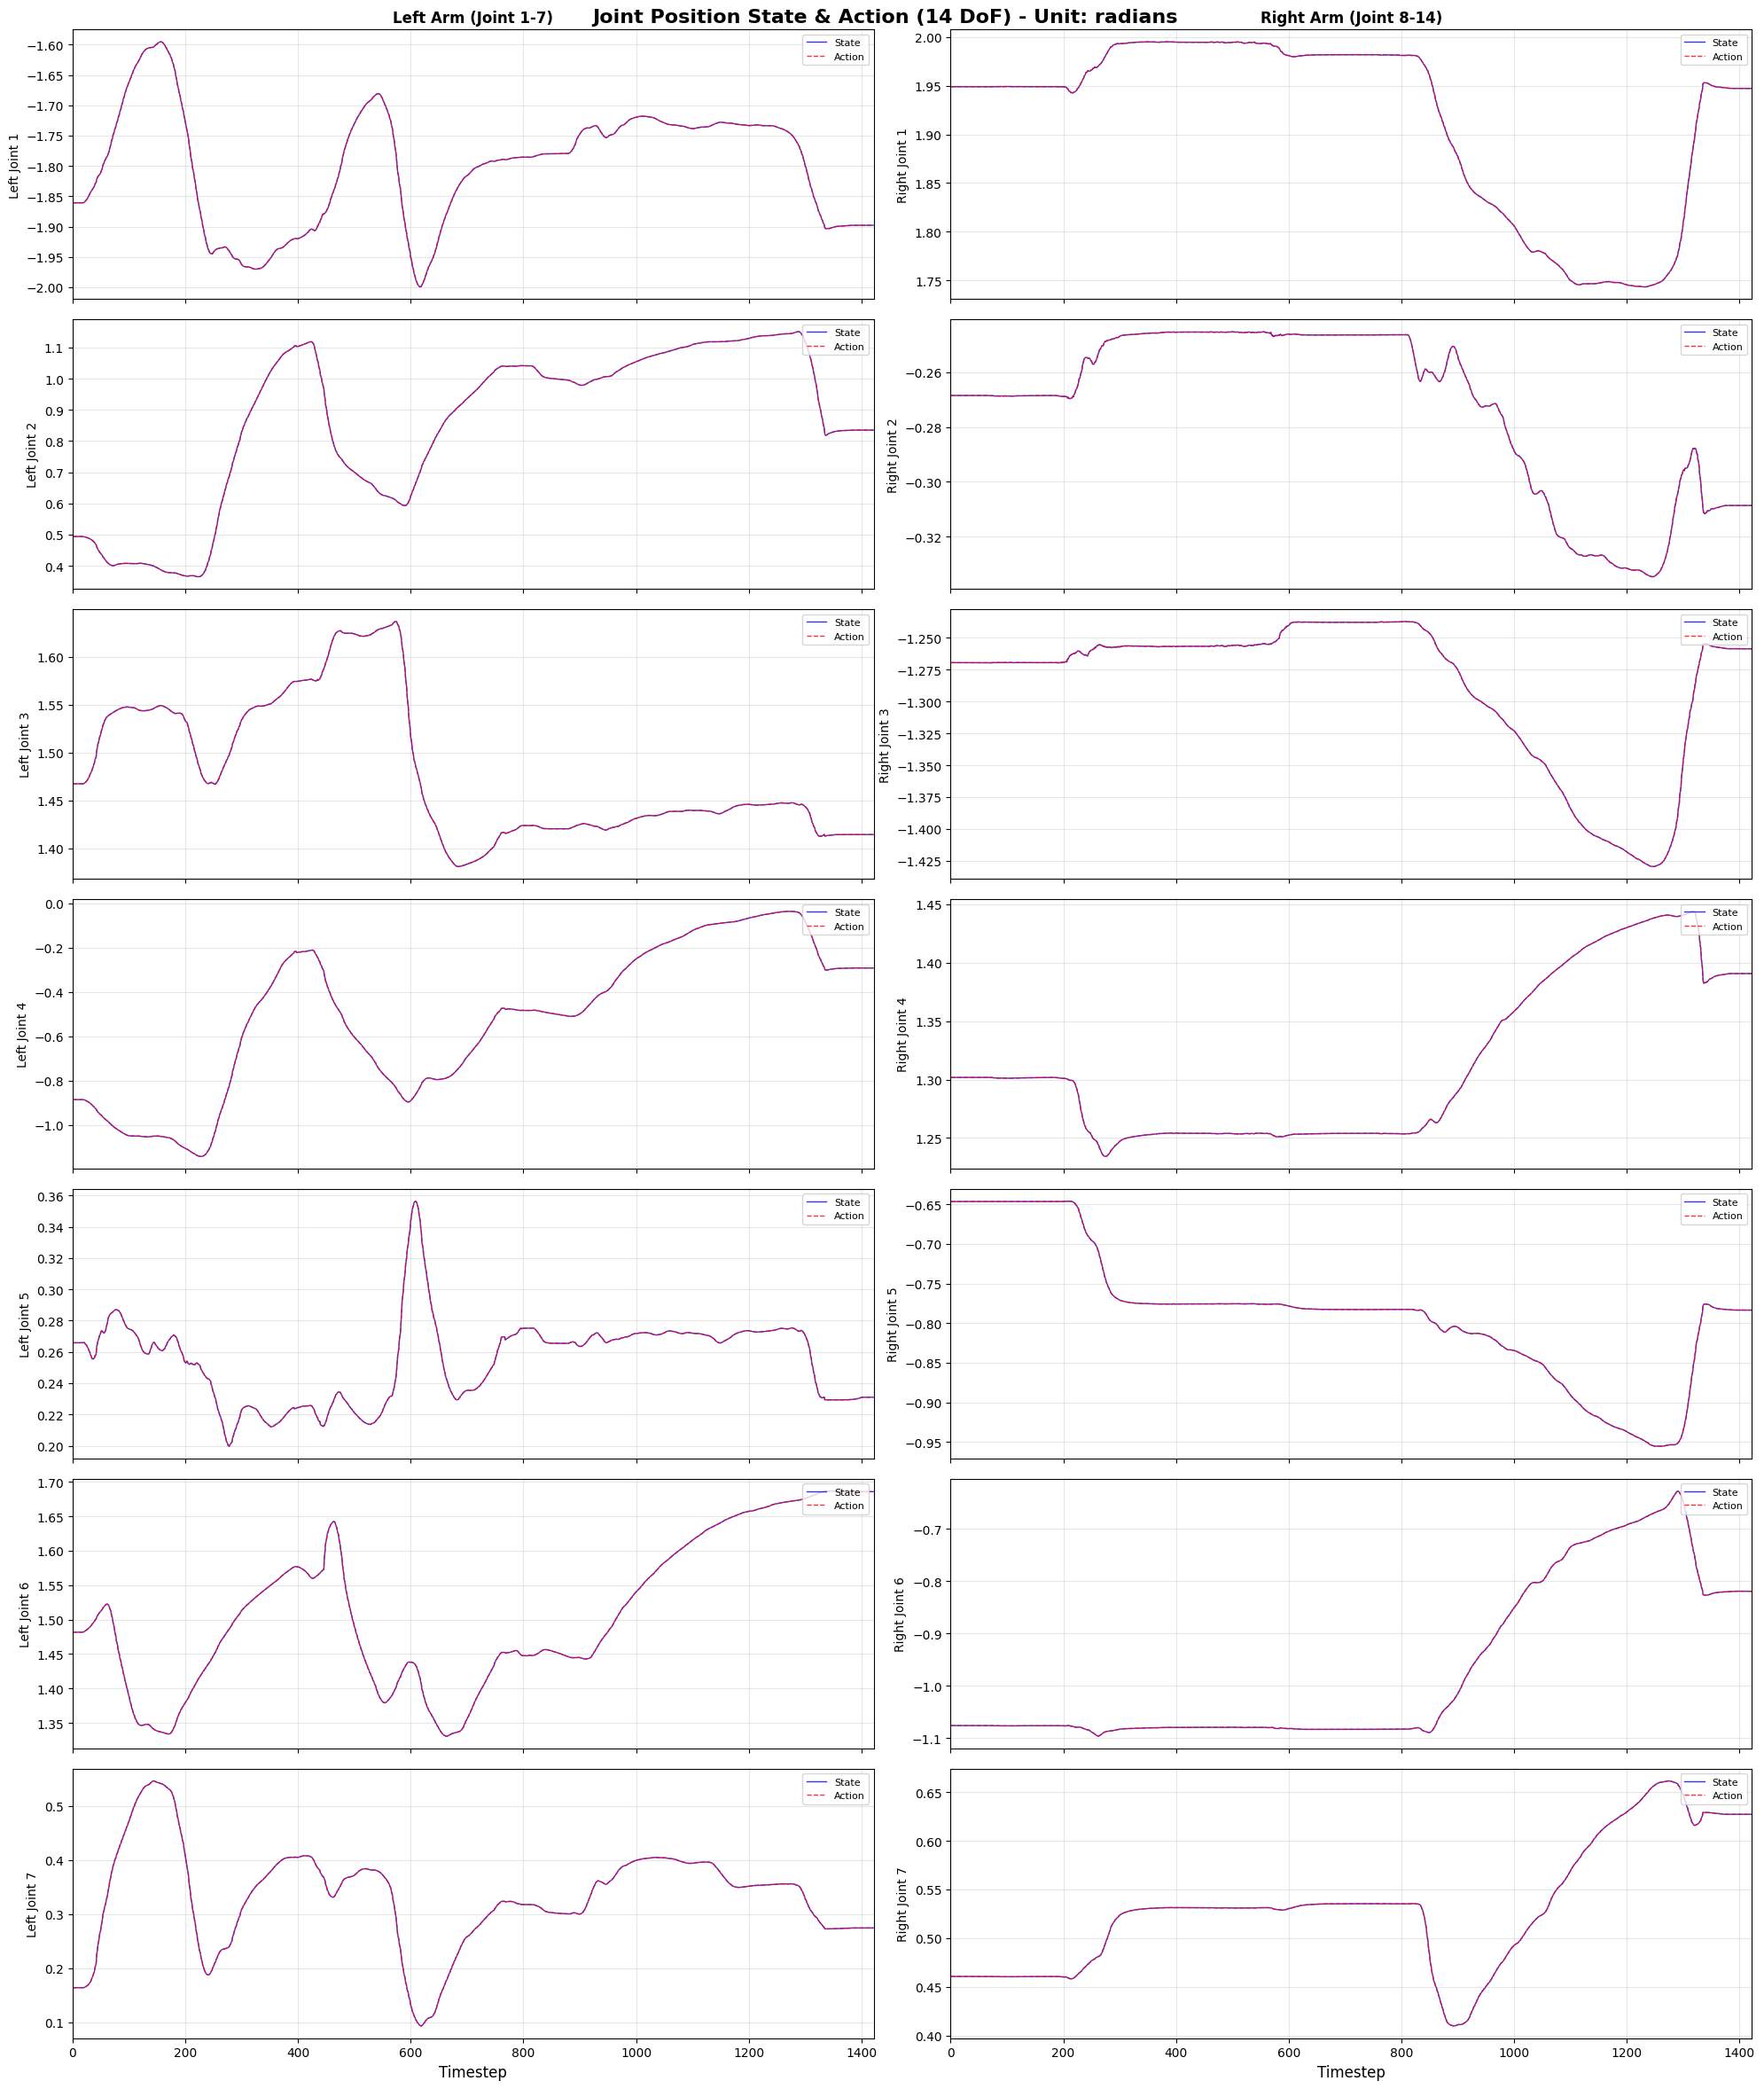

In [4]:
"""
绘制 state 和 action 的关节角度 14 自由度曲线
- joint position (14D): 左臂 7个 + 右臂 7个 (弧度)
"""

import h5py
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path


# 读取数据
with h5py.File(path, "r") as f:
    # Action: joint
    action_joint_position = f["action/joint/position"][:]      # (2418, 14)
    
    # State: joint
    state_joint_position = f["state/joint/position"][:]        # (2418, 14)

print(f"Action joint position shape: {action_joint_position.shape}")
print(f"State joint position shape: {state_joint_position.shape}")

# 时间轴
timesteps = np.arange(action_joint_position.shape[0])  # 2418

# 创建图表 - 14个子图 (分为两列: 左臂7个 + 右臂7个)
fig, axes = plt.subplots(7, 2, figsize=(20, 24), sharex=True)
fig.suptitle('Joint Position State & Action (14 DoF) - Unit: radians', fontsize=16, fontweight='bold')

# 关节标签
joint_labels = [f'Joint {i+1}' for i in range(7)]

# 绘制左臂 (前7个关节)
for i in range(7):
    ax = axes[i, 0]
    ax.plot(timesteps, state_joint_position[:, i], 'b-', label='State', alpha=0.8, linewidth=1)
    ax.plot(timesteps, action_joint_position[:, i], 'r--', label='Action', alpha=0.8, linewidth=1)
    ax.set_ylabel(f'Left {joint_labels[i]}', fontsize=10)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, len(timesteps)])

# 绘制右臂 (后7个关节)
for i in range(7):
    ax = axes[i, 1]
    ax.plot(timesteps, state_joint_position[:, i+7], 'b-', label='State', alpha=0.8, linewidth=1)
    ax.plot(timesteps, action_joint_position[:, i+7], 'r--', label='Action', alpha=0.8, linewidth=1)
    ax.set_ylabel(f'Right {joint_labels[i]}', fontsize=10)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, len(timesteps)])

# 设置x轴标签
axes[-1, 0].set_xlabel('Timestep', fontsize=12)
axes[-1, 1].set_xlabel('Timestep', fontsize=12)

# 设置列标题
axes[0, 0].set_title('Left Arm (Joint 1-7)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Right Arm (Joint 8-14)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [5]:


with h5py.File(path, "r") as f:
    action_joint = f["action/joint/position"][:]
    state_joint = f["state/joint/position"][:]

# 计算差异
diff = action_joint - state_joint
print(f"差异统计:")
print(f"  - 最大差异: {np.max(np.abs(diff)):.6f} rad")
print(f"  - 平均差异: {np.mean(np.abs(diff)):.6f} rad")
print(f"  - 标准差: {np.std(diff):.6f} rad")
print(f"  - 是否完全相同: {np.allclose(action_joint, state_joint)}")

差异统计:
  - 最大差异: 0.000000 rad
  - 平均差异: 0.000000 rad
  - 标准差: 0.000000 rad
  - 是否完全相同: True
